In [1]:
# Initialization: imports and formatting
# Formatting Code
from pathlib import Path
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import matplotlib.gridspec as gridspec

import os
import glob

from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
import scipy
# check scipy version:
print(scipy.__version__)
# if scipy version lower than 1.16.0, use the following line
# from scipy.integrate import simps
# if scipy version 1.16.0 or higher, use the following line
from scipy.integrate import simpson as simps

font='Tahoma'
fontsize=22
plwidth=6.5
lw = 2
padlen = 15
ticklen = lw*5
tickdir = 'in'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Bitstream Vera Sans', 'Computer Modern Sans Serif', 'Lucida Grande', 'Verdana', 'Geneva', 'Lucid', 'Arial', 'Helvetica', 'Avant Garde', 'sans-serif', 'Tahoma']

params = {'legend.fontsize': 'large',
        'font.family': 'sans-serif',
        'font.sans-serif': font,
        'font.weight': 'regular',
        'axes.labelsize': fontsize,
        'axes.titlesize': fontsize,
        'legend.fontsize': fontsize,
        'xtick.labelsize': fontsize,
        'xtick.major.width': lw,
        'xtick.major.size': ticklen,
        'xtick.minor.visible': True,
        'xtick.minor.width': 3/4*lw,
        'xtick.minor.size': ticklen/2,
        'ytick.labelsize': fontsize,
        'ytick.major.width': lw,
        'ytick.major.size': ticklen,
        'ytick.minor.visible': True,
        'ytick.minor.width': 3/4*lw,
        'ytick.minor.size': ticklen/2,
        'axes.labelweight': 'regular',
        'axes.linewidth': lw,
        'axes.titlepad': 25,
        'xtick.direction': tickdir,
        'ytick.direction': tickdir,
        'xtick.major.pad': 15,
        'ytick.major.pad': 15,
        'xtick.minor.pad': 15,
        'ytick.minor.pad': 15,
        'xtick.top': True,       
        'ytick.right': True,     
        'axes.edgecolor': 'k',  
        'xtick.color': 'k',       
        'ytick.color': 'k',       
        }
plt.rcParams.update(params)

1.11.1


# Deconvolution Functions

In [2]:
# Deconvolution functions

# The functions used are defined at a preparation step and a deconvolution step
# These are combined as import_run_CV_deconvolution(folder_path, v_input=1, reference='Ag|AgCl')

# Loading data: takes a folder path as input and returns curves and scan rates
# where folder_path is the path to a folder containing CVs at different scan rates in csv files
# where the CVs have the format: E, I, t in three columns

def prepare_data(folder_path, reference='Ag|AgCl'):

    def read_data_from_file(file_path):
        """Read E, I, t from a data file.
        Assumes the file has three columns: E, I, t.
        Assumes the order of columns is: E, I, t.
        """
        data = np.loadtxt(file_path)  
        column1 = data[:, 0]  # potential (E)
        column2 = data[:, 1]  # current (I)
        column3 = data[:, 2]  # time (t)
        return column1, column2, column3

    def load_cv_folder(folder_path):
        """
        Reads all .csv files in a folder and returns:
        - curves: list of (E, I) tuples
        - scan_rates: list of scan rates (mV/s)
        - file_paths: list of file paths (for reference if needed)
        """
        # Find all CSV files in the folder
        file_paths = sorted(glob.glob(os.path.join(folder_path, '*.csv')))
        if not file_paths:
            raise FileNotFoundError(f"No .csv files found in folder: {folder_path}")

        curves = []
        Es = []
        Is = []
        scan_rates = []
        scan_rates_unsorted = []

        for fp in file_paths:
            E, I, t = read_data_from_file(fp)

            # Compute scan rate
            # v = |(E[50] - E[1]) / (t[50] - t[1]) * 1000|
            if len(E) <= 50 or len(t) <= 50:
                raise ValueError(f"Not enough data points in file: {fp} (needs > 50 rows)")

            v = np.abs((E[50] - E[1]) / (t[50] - t[1]) * 1000.0)  # mV/s

            Es.append(E)
            Is.append(I)
            scan_rates_unsorted.append(v)

        #sort curves by scan rate (e.g., lowest to highest)
        order = np.argsort(scan_rates_unsorted)  # ascending order of scan rate
        
        # order curves and scan rates accorinding to ascending order of scan rates
        for idx in order:
            curves.append((Es[idx], Is[idx]))
            scan_rates.append(scan_rates_unsorted[idx])

        return curves, scan_rates
    
    curves, scan_rates = load_cv_folder(folder_path)

    plt.figure(figsize=(plwidth, plwidth))

    for E,I in curves:
        plt.plot(E, I, linewidth=2)

    # Build legend labels from scan_rates
    legend_labels = [f'{scan_rate:.1f} mV/s' for scan_rate in scan_rates]
    plt.legend(legend_labels, fontsize=fontsize, frameon=False)

    current_string = "Current, $i$ / mA"
    plt.xlabel(f'Potential, E $\\it{{vs.}}$$\\mathrm{{{reference}}}$ / V', fontsize=fontsize)
    plt.ylabel(current_string, fontsize=fontsize)
    plt.tick_params(axis='both', labelsize=fontsize)

    plt.tight_layout()
    plt.show()

    return curves, scan_rates

# Deconvolution

# deconvolute_CV take the inputs from prepare_data(folder_path) where folder_path 
# is the path to a folder containing CVs at different scan rates in csv files
# where the CVs have the format: E, I, t in three columns

# curves     = [(E1, I1), (E2, I2), ..., (EN, IN)]
# scan_rates = [v1, v2, ..., vN]   (in mV/s)

def deconvolute_CV(curves, scan_rates, v_input=1, reference='Ag|AgCl'):

    colours = ["#d95f02", "#7570b3", "#1b9e77"]

    # Check for data
    num_cvs = len(curves)
    if num_cvs == 0:
        raise RuntimeError("No CVs found in 'curves'. Did script 1 run correctly?")

    # x: scan rates used in fitting ([v1, v2, ...])
    x = np.array(scan_rates, dtype=float)  # mV/s

    v_input = int(v_input)

    if not (1 <= v_input <= num_cvs):
        raise ValueError(f"Invalid choice {v_input}. Please choose a number between 1 and {num_cvs}.")

    chosen_idx = v_input - 1
    potential, current = curves[chosen_idx]
    scan_rate = scan_rates[chosen_idx]

    # Arrays for decomposition results
    ifara = []
    icapa = []
    ipseudo = []
    voltage_p = []
    voltage_n = []

    # Use the chosen CV's current as the sign reference (instead of hard-coded column2)
    ref_current = current

    # Deconvolution loop over all potentials
    for i in range(len(potential)):
        # Collect currents at this same index from ALL scan rates
        currents_at_i = [curves[j][1][i] for j in range(num_cvs)]

        if ref_current[i] < 0:
            y = [-c for c in currents_at_i]
        else:
            y = [c for c in currents_at_i]

        y = np.array(y, dtype=float)

        # Define the model function: i = a*v^0.5 + b*v + c*v^1.5
        def model(v, a, b, c):
            return a * np.sqrt(v) + b * v + c * v**1.5

        # Perform curve fitting with non-negative constraints on a, b, c
        params, covariance = curve_fit(model, x, y, bounds=(0, np.inf))
        a, b, c = params

        # Compute components at the chosen scan rate
        if ref_current[i] < 0:
            ifarad = -a * np.sqrt(scan_rate)
            icapac = -b * scan_rate
            ipseudoc = -c * scan_rate**1.5
            voltage_n.append(potential[i])
        else:
            ifarad = a * np.sqrt(scan_rate)
            icapac = b * scan_rate
            ipseudoc = c * scan_rate**1.5
            voltage_p.append(potential[i])

        ifara.append(ifarad)
        icapa.append(icapac)
        ipseudo.append(ipseudoc)

    # Convert lists to numpy arrays
    ifara = np.array(ifara)
    icapa = np.array(icapa)
    ipseudo = np.array(ipseudo)
    voltage_p = np.array(voltage_p)
    voltage_n = np.array(voltage_n)

    # Predicted vs real current
    i_predict = ifara + icapa + ipseudo
    i_real = np.array(current)

    # Compute R²
    r2 = r2_score(i_real, i_predict)

    #PLOT
    fig = plt.figure(figsize=(plwidth*2.25, plwidth))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1,1], height_ratios=[1])

    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])

    # font sizes
    label_fs = 22
    tick_fs = 22
    title_fs = 22
    legend_fs = 18

    # Global title
    title = f"Charge Contributions @v={scan_rate:.2f} mV/s  R-Squared: {r2:.2f}"
    fig.suptitle(title, fontsize=title_fs, y=1.15, x=0.4)

    #Panel A: CV + decomposition
    ax1.stackplot(potential, ifara, icapa, ipseudo,
                labels=['i Faradaic', 'i Capacitive', 'i Pseudocapacitive'],
                colors=[colours[0], colours[1], colours[2]])

    ax1.plot(potential, current, linewidth=2, color='black',
            label=f"i total @v={scan_rate:.2f} mV/s")

    current_string = "Current, $i$ / mA"
    ax1.set_xlabel(f'Potential, E $\\it{{vs.}}$$\\mathrm{{{reference}}}$ / V',
                fontsize=label_fs)
    ax1.set_ylabel(current_string, fontsize=label_fs)
    ax1.tick_params(axis='both', labelsize=tick_fs)

    ax1.set_ylim(min(i_real.min(), i_predict.min()) * 1.1,
                max(i_real.max(), i_predict.max()) * 1.1)

    ax1.minorticks_on()
    ax1.tick_params(axis='x', which='minor', bottom=False, top=False)

    ax1.tick_params(axis='both', which='major',
                    direction='in',
                    length=6, width=1.3,
                    pad=4,
                    top=True, right=True)

    ax1.tick_params(axis='y', which='minor',
                    direction='in',
                    length=3, width=1.0)

    for spine in ax1.spines.values():
        spine.set_linewidth(1.3)

    #Charge calculations
    ifara_p = []
    ifara_n = []
    icapa_p = []
    icapa_n = []
    ipseudo_p = []
    ipseudo_n = []

    for i in ifara:
        if i >= 0:
            ifara_p = np.append(ifara_p, i)
        else:
            ifara_n = np.append(ifara_n, i)

    for i in icapa:
        if i >= 0:
            icapa_p = np.append(icapa_p, i)
        else:
            icapa_n = np.append(icapa_n, i)

    for i in ipseudo:
        if i >= 0:
            ipseudo_p = np.append(ipseudo_p, i)
        else:
            ipseudo_n = np.append(ipseudo_n, i)

    Qfaradaic_p = np.abs(np.trapz(y=ifara_p, x=voltage_p))
    Qfaradaic_n = np.abs(np.trapz(y=ifara_n, x=voltage_n))
    QCapacitive_p = np.abs(np.trapz(y=icapa_p, x=voltage_p))
    QCapacitive_n = np.abs(np.trapz(y=icapa_n, x=voltage_n))
    QPseudo_p = np.abs(np.trapz(y=ipseudo_p, x=voltage_p))
    QPseudo_n = np.abs(np.trapz(y=ipseudo_n, x=voltage_n))

    Qtotal_red = Qfaradaic_n + QCapacitive_n + QPseudo_n
    Qtotal_ox = Qfaradaic_p + QCapacitive_p + QPseudo_p

    Qf_P_red   = Qfaradaic_n / Qtotal_red
    Qf_P_ox    = Qfaradaic_p / Qtotal_ox
    Qf_P_total = (Qfaradaic_p + Qfaradaic_n) / (Qtotal_ox + Qtotal_red)

    QC_P_red   = QCapacitive_n / Qtotal_red
    QC_P_ox    = QCapacitive_p / Qtotal_ox
    QC_P_total = (QCapacitive_p + QCapacitive_n) / (Qtotal_ox + Qtotal_red)

    QP_P_red   = QPseudo_n / Qtotal_red
    QP_P_ox    = QPseudo_p / Qtotal_ox
    QP_P_total = (QPseudo_p + QPseudo_n) / (Qtotal_ox + Qtotal_red)

    #Panel B: Bar chart
    x_axis = ['Reduction', 'Oxidation', 'Total']
    mechanisms = ['Faradaic', 'Capacitive', 'Pseudocapacitive']

    data = np.array([
        [Qf_P_red * 100,   QC_P_red * 100,   QP_P_red * 100],    # Red  
        [Qf_P_ox * 100,    QC_P_ox * 100,    QP_P_ox * 100],     # Ox
        [Qf_P_total * 100, QC_P_total * 100, QP_P_total * 100]   # Total
    ])

    x_pos = np.arange(len(x_axis))
    width = 0.25
    colors = ["#d95f02", "#7570b3", "#1b9e77"]  # Panel B colors

    bars1 = ax2.bar(x_pos - width, data[:, 0], width, label='Faradaic',
                    color=colors[0])
    bars2 = ax2.bar(x_pos,          data[:, 1], width, label='Capacitive',
                    color=colors[1])
    bars3 = ax2.bar(x_pos + width,  data[:, 2], width, label='Pseudocapacitive',
                    color=colors[2])

    # Panel B formatting
    ax2.set_ylim(0, 119.9)
    ax2.set_yticks(np.arange(0, 119.9, 20))

    ax2.minorticks_on()
    ax2.tick_params(axis='x', which='minor', bottom=False, top=False)

    ax2.tick_params(axis='both', which='major',
                    direction='in',
                    length=6, width=1.3,
                    pad=4,
                    top=True, right=True)

    ax2.tick_params(axis='y', which='minor',
                    direction='in',
                    length=3, width=1.0)

    for spine in ax2.spines.values():
        spine.set_linewidth(1.3)

    ax2.set_ylabel('Contribution to total current / %', fontsize=label_fs)
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(x_axis, fontsize=tick_fs)
    ax2.tick_params(axis='y', labelsize=tick_fs)

    # legend
    legend = ax1.legend(loc='upper center',
                        bbox_to_anchor=(1.125, 1.25),
                        borderaxespad=0.,
                        frameon=False,
                        ncol=2,
                        fontsize=legend_fs)
    # function to add labels on top of bars
    def add_labels(bars, axis):
        for b in bars:
            h = b.get_height()
            axis.text(b.get_x() + b.get_width() / 2, h + 3.5,
                    f"{h:.2f}%",
                    ha='center', va='bottom',
                    rotation=90,
                    fontsize=legend_fs, fontweight='bold')
    # adding bar labels with percentages
    add_labels(bars1, ax2)
    add_labels(bars2, ax2)
    add_labels(bars3, ax2)

    fig.subplots_adjust(left=0.10, right=0.80, top=0.88, bottom=0.18, wspace=0.40)

    plt.show()

    results = {
        "Faradaic Contribution Reduction": Qf_P_red,
        "Faradaic Contribution Oxidation": Qf_P_ox,
        "Faradaic Contribution Total": Qf_P_total,
        "Capacitive Contribution Reduction": QC_P_red,
        "Capacitive Contribution Oxidation": QC_P_ox,
        "Capacitive Contribution Total": QC_P_total,
        "Pseudocapacitive Contribution Reduction": QP_P_red,
        "Pseudocapacitive Contribution Oxidation": QP_P_ox,
        "Pseudocapacitive Contribution Total": QP_P_total,
        "r2": r2
    }

    return results

def import_run_CV_deconvolution(folder_path, v_input=1, reference='Ag|AgCl'):
    curves, scan_rates = prepare_data(folder_path, reference=reference)
    results = deconvolute_CV(curves, scan_rates, v_input=v_input, reference=reference)
    return results

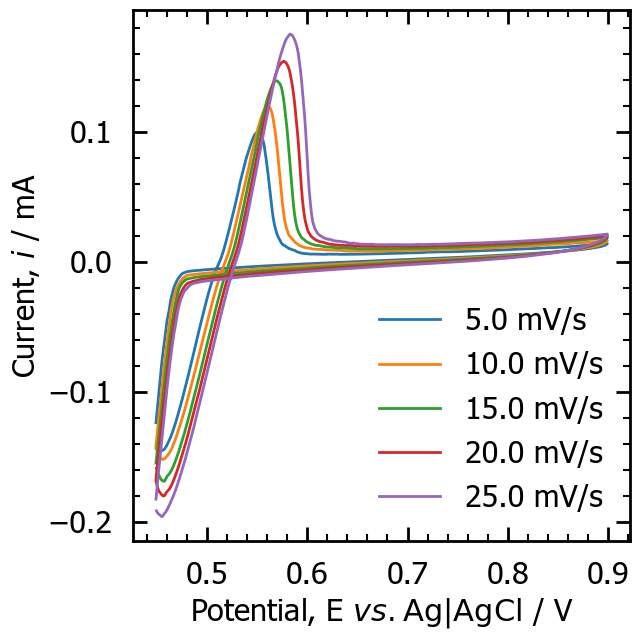

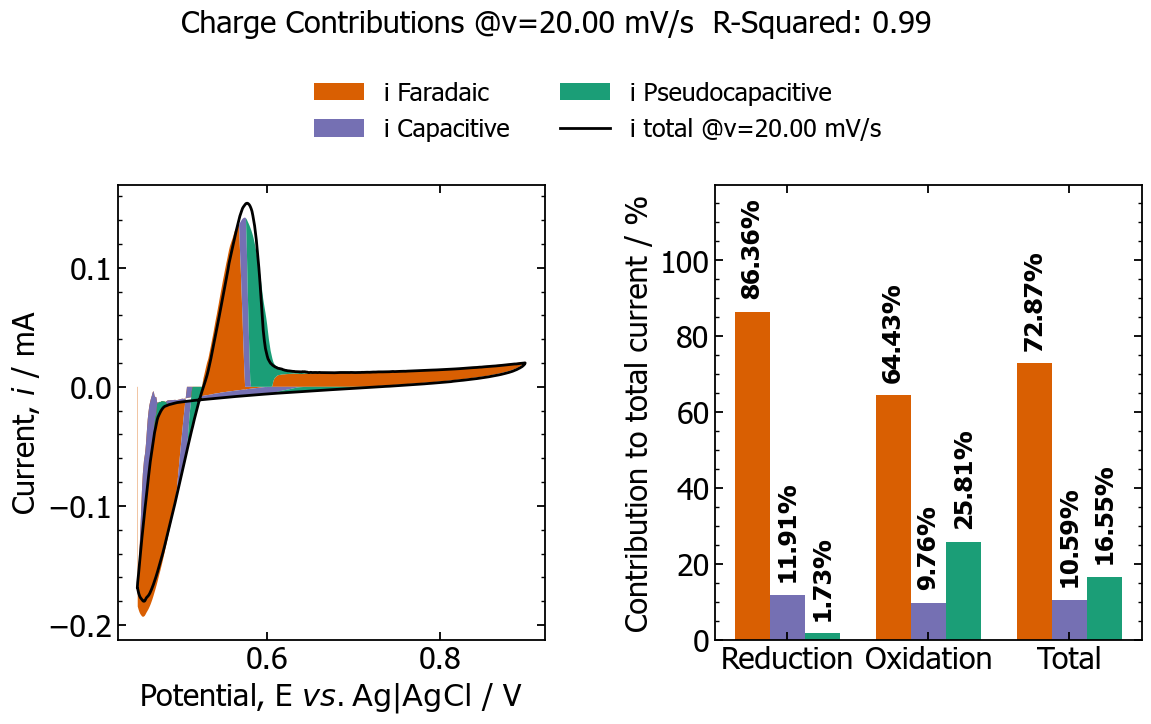

In [3]:
folder = 'AgNO3'  # Change this folder as needed
scan_rate_number = 4  # scan rate number to choose, e.g., 1 for the first (lowest) rate
reference_text = 'Ag|AgCl'  # text for axis labels: Potential, E vs. {reference_text} / V, default is 'Ag|AgCl'

results = import_run_CV_deconvolution(folder, v_input=scan_rate_number, reference=reference_text)